# What is the notebook about?

## Problem - Taxi Environment Algorithms
This problem deals with a taxi environment and stochastic actions. The tasks you have to do are:
- Implement Policy Iteration
- Visualize the results
- Explain the results

## How to use this notebook? 📝

- This is a shared template and any edits you make here will not be saved.**You
should make a copy in your own drive**. Click the "File" menu (top-left), then "Save a Copy in Drive". You will be working in your copy however you like.

- **Update the config parameters**. You can define the common variables here

Variable | Description
--- | ---
`AICROWD_DATASET_PATH` | Path to the file containing test data. This should be an absolute path.
`AICROWD_RESULTS_DIR` | Path to write the output to.
`AICROWD_ASSETS_DIR` | In case your notebook needs additional files (like model weights, etc.,), you can add them to a directory and specify the path to the directory here (please specify relative path). The contents of this directory will be sent to AIcrowd for evaluation.
`AICROWD_API_KEY` | In order to submit your code to AIcrowd, you need to provide your account's API key. This key is available at https://www.aicrowd.com/participants/me

- **Installing packages**. Please use the [Install packages 🗃](#install-packages-) section to install the packages

# Setup AIcrowd Utilities 🛠

We use this to bundle the files for submission and create a submission on AIcrowd. Do not edit this block.

In [ ]:
!pip install -U aicrowd-cli > /dev/null 

# AIcrowd Runtime Configuration 🧷

Define configuration parameters.

In [ ]:
import os

AICROWD_DATASET_PATH = os.getenv("DATASET_PATH", os.getcwd()+"/407e4f07-d470-427d-8758-4f888ae03fe6_data.zip")
AICROWD_RESULTS_DIR = os.getenv("OUTPUTS_DIR", "results")
API_KEY = "7e057d0030fa8b2556c46e257b516e0a" # Get your key from https://www.aicrowd.com/participants/me (ctrl + click the link)

In [ ]:
!aicrowd login --api-key $API_KEY
!aicrowd dataset download -c rl-assignment-2-taxi

API Key valid
Saved API Key successfully!
407e4f07-d470-427d-8758-4f888ae03fe6_data.zip: 100% 16.8k/16.8k [00:00<00:00, 198kB/s]


In [ ]:
DATASET_DIR = 'data/'
!unzip $AICROWD_DATASET_PATH


Archive:  /content/407e4f07-d470-427d-8758-4f888ae03fe6_data.zip
replace __MACOSX/._data? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/._data         
  inflating: __MACOSX/data/._targets  
  inflating: __MACOSX/data/._inputs  
  inflating: data/targets/targets_2.npy  
  inflating: __MACOSX/data/targets/._targets_2.npy  
  inflating: data/targets/targets_0.npy  
  inflating: __MACOSX/data/targets/._targets_0.npy  
  inflating: data/targets/targets_1.npy  
  inflating: __MACOSX/data/targets/._targets_1.npy  
  inflating: data/targets/targets_base.npy  
  inflating: __MACOSX/data/targets/._targets_base.npy  
  inflating: data/inputs/inputs_base.npy  
  inflating: __MACOSX/data/inputs/._inputs_base.npy  
  inflating: data/inputs/inputs_1.npy  
  inflating: __MACOSX/data/inputs/._inputs_1.npy  
  inflating: data/inputs/inputs_0.npy  
  inflating: __MACOSX/data/inputs/._inputs_0.npy  
  inflating: data/inputs/inputs_2.npy  
  inflating: __MACOSX/data/inputs/._inputs_2.npy  

# Install packages 🗃

Please add all package installations in this section

# Import packages 💻

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import os
# ADD ANY IMPORTS YOU WANT HERE


# Prediction Phase

## Taxi Environment

Read the environment to understand the functions, but do not edit anything

In [ ]:
import numpy as np

In [ ]:

class TaxiEnv_HW2:
    
    def __init__(self, states, actions, probabilities, rewards, initial_policy):        
        probabilities, rewards = self._build_prob_mapping(states, actions, probabilities,rewards)
        self.possible_states = states
        self._possible_actions = {st: actions for st in states}
        self._ride_probabilities = {st: pr for st, pr in zip(states, probabilities)}
        self._ride_rewards = {st: rw for st, rw in zip(states, rewards)}
        self.initial_policy = initial_policy
        self._verify()

    def _build_prob_mapping(self,states, actions, probabilities,rewards):
        n_cities = len(states)
        n_actions = len(actions)

        probs = np.zeros((n_cities, n_actions, n_cities))
        
        rewards[0] = [0,0,0,0,0,0]    
        rews = np.zeros((n_cities, n_actions, n_cities))

        for src in range(n_cities):
          for action in ('1', '2'):
              for c, prob in probabilities[action].items():
                  dst = (src+c) % n_cities
                  probs[src][actions.index(action)][dst] = prob
                  rews[src][actions.index(action)][dst] = rewards[c][src]
          action = '3'
          action = actions.index(action)
          probs[src][action][0] = 1
        return probs, rews

    def _check_state(self, state):
        assert state in self.possible_states, "State %s is not a valid state" % state

    def _verify(self):
        """ 
        Verify that data conditions are met:
        Number of actions matches shape of next state and actions
        Every probability distribution adds up to 1 
        """
        ns = len(self.possible_states)
        for state in self.possible_states:
            ac = self._possible_actions[state]
            na = len(ac)
            rp = self._ride_probabilities[state]
            assert np.all(rp.shape == (na, ns)), "Probabilities shape mismatch"
        
            rr = self._ride_rewards[state]
            assert np.all(rr.shape == (na, ns)), "Rewards shape mismatch"

            assert np.allclose(rp.sum(axis=1), 1), "Probabilities don't add up to 1"

    def possible_actions(self, state):
        """ Return all possible actions from a given state """
        self._check_state(state)
        return self._possible_actions[state]

    def ride_probabilities(self, state, action):
        """ 
        Returns all possible ride probabilities from a state for a given action
        For every action a list with the returned with values in the same order as self.possible_states
        """
        actions = self.possible_actions(state)
        ac_idx = actions.index(action)
        return self._ride_probabilities[state][ac_idx]

    def ride_rewards(self, state, action):
        actions = self.possible_actions(state)
        ac_idx = actions.index(action)
        return self._ride_rewards[state][ac_idx]

## Example of Environment usage

In [ ]:
import numpy as np 

def check_taxienv():
    # These are the values as used in the assignment document, but they may be changed during submission, so do not hardcode anything

    states = [0, 1, 2, 3, 4, 5]

    actions = ['1','2','3']

    probs = {}
    probs['1'] = {-1: 1/2, 0: 1/4, 1: 1/4}
    probs['2'] = {-1: 1/16, 0: 3/4, 1: 3/16}

    rewards = {}
    rewards[-1] = [8,7,3,2,1,2]
    rewards[1]  = [8,8,5,1,3,9]

    initial_policy = {0:'1', 1:'1', 2:'1', 3:'1', 4:'1', 5:'1'}

    ##################################


    env = TaxiEnv_HW2(states, actions, probs, rewards, initial_policy)
    print("All possible states", env.possible_states)
    print("All possible actions from state B", env.possible_actions(1))
    print("Ride probabilities from state A with action 2", env.ride_probabilities(2, '2'))
    print("Ride rewards from state C with action 3", env.ride_rewards(4, '1'))

    base_kwargs = {"states": states, "actions": actions, 
                "probabilities": probs, "rewards": rewards,
                "initial_policy": initial_policy}
    return base_kwargs

base_kwargs = check_taxienv()

All possible states [0, 1, 2, 3, 4, 5]
All possible actions from state B ['1', '2', '3']
Ride probabilities from state A with action 2 [0.     0.0625 0.75   0.1875 0.     0.    ]
Ride rewards from state C with action 3 [0. 0. 0. 1. 0. 3.]


## Task - Policy Iteration
Run policy iteration on the environment and generate the policy and expected reward

In [ ]:
# 1.1 Policy Iteration
def policy_iteration(taxienv, gamma):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    N = len(states)

    done = 0
    count = 0
    while not done:
    # Policy evaluation
      count +=1
      diff_max = 1
      J = np.zeros(shape=N)
      while diff_max>=1e-8:
        Jprev_VI = np.copy(J)
        diff_max = 0
        for i in range(N):
          state = states[i]
          action = policy[state]
          pij = np.array(taxienv.ride_probabilities(state,action))
          g = np.array(taxienv.ride_rewards(state,action))
          J[i] = sum(np.multiply(pij,g+gamma*Jprev_VI))
          diff_max = max(abs(J[i]-Jprev_VI[i]),diff_max)
      i  = 0
      for state in values.keys():
        values[state] = J[i]
        i += 1
      done = 1

      # Policy Update
      
      for i in range(N):
      # Initialise state value and available actions
        state = states[i]
        actions = taxienv.possible_actions(state)

        # Set best action and value as current action and values
        max_val = J[i]
        best_action = policy[state]

        for action in actions:
          pij = np.array(taxienv.ride_probabilities(state,action))
          g = np.array(taxienv.ride_rewards(state,action))
          a_value = sum(np.multiply(pij,g+gamma*J))
          if max_val < a_value:
            max_val = a_value
            best_action = action
        # Check if new policy is same as old policy
        if policy[state] != best_action:
          done = 0
        policy[state] = best_action

    # Put your extra information needed for plots etc in this dictionary
    extra_info = {"number_iter":count}

    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

Policy Iteration with different values of gamma


In [ ]:
# 1.2 Policy Iteration with different values of gamma
def run_policy_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = policy_iteration(env, gamma)
    return results, extra_info

In [ ]:
# Do not edit this cell
def get_results(kwargs):

    taxienv = TaxiEnv_HW2(**kwargs)

    policy_iteration_results = run_policy_iteration(taxienv)[0]

    final_results = {}
    final_results["policy_iteration"] = policy_iteration_results

    return final_results

In [ ]:
get_results(base_kwargs)

{'policy_iteration': {0.05: {'Expected Reward': {0: 6.235100376707697,
    1: 5.7647865549485084,
    2: 2.9479370977961303,
    3: 1.3574576265751364,
    4: 1.3432783145586729,
    5: 3.404071607538855},
   'Policy': {0: '1', 1: '1', 2: '1', 3: '1', 4: '1', 5: '1'}},
  0.1: {'Expected Reward': {0: 6.492397996301435,
    1: 6.05522632007875,
    2: 3.1690305036493456,
    3: 1.4817370154840632,
    4: 1.449682610049221,
    5: 3.5741477744371872},
   'Policy': {0: '1', 1: '1', 2: '1', 3: '1', 4: '1', 5: '1'}},
  0.15: {'Expected Reward': {0: 6.775385850222733,
    1: 6.375378843246467,
    2: 3.417285287685362,
    3: 1.6262313755872122,
    4: 1.5720347429184187,
    5: 3.7630956619928337},
   'Policy': {0: '1', 1: '1', 2: '1', 3: '1', 4: '1', 5: '1'}},
  0.2: {'Expected Reward': {0: 7.088385029530172,
    1: 6.730233583076426,
    2: 3.6976680302982676,
    3: 1.7952254204109084,
    4: 1.713946938123561,
    5: 3.9745409944646655},
   'Policy': {0: '1', 1: '1', 2: '1', 3: '1', 4: '

In [ ]:
if not os.path.exists(AICROWD_RESULTS_DIR):
  os.mkdir(AICROWD_RESULTS_DIR)
if not os.path.exists(DATASET_DIR+'/inputs'):
  os.mkdir(DATASET_DIR+'/inputs')

In [ ]:
# Do not edit this cell, generate results with it as is

input_dir = os.path.join(DATASET_DIR, 'inputs')

if not os.path.exists(AICROWD_RESULTS_DIR):
    os.mkdir(AICROWD_RESULTS_DIR)

for params_file in os.listdir(input_dir):
  kwargs = np.load(os.path.join(input_dir, params_file), allow_pickle=True).item()
  print(kwargs)
  results = get_results(kwargs)
  idx = params_file.split('_')[-1][:-4]
  np.save(os.path.join(AICROWD_RESULTS_DIR, 'results_' + idx), results)

{'states': [0, 1, 2, 3, 4], 'actions': ['1', '2', '3'], 'probabilities': {'1': {-1: 0.013212886953789417, 0: 0.265387928772242, 1: 0.7213991842739688}, '2': {-1: 0.013212886953789417, 0: 0.265387928772242, 1: 0.7213991842739688}}, 'rewards': {-1: [4, 4, 2, 7, 2], 1: [3, 4, 3, 5, 4], 0: [0, 0, 0, 0, 0, 0]}, 'initial_policy': {0: '1', 1: '1', 2: '1', 3: '1', 4: '1'}}
{'states': [0, 1, 2, 3, 4], 'actions': ['1', '2', '3'], 'probabilities': {'1': {-1: 0.8668133321973345, 0: 0.01587623997646676, 1: 0.1173104278261983}, '2': {-1: 0.8668133321973345, 0: 0.01587623997646676, 1: 0.1173104278261983}}, 'rewards': {-1: [6, 4, 7, 4, 4], 1: [7, 5, 5, 2, 4], 0: [0, 0, 0, 0, 0, 0]}, 'initial_policy': {0: '1', 1: '1', 2: '1', 3: '1', 4: '1'}}
{'states': [0, 1, 2, 3], 'actions': ['1', '2', '3'], 'probabilities': {'1': {-1: 0.6652409557748217, 0: 0.24472847105479759, 1: 0.09003057317038043}, '2': {-1: 0.6652409557748217, 0: 0.24472847105479759, 1: 0.09003057317038043}}, 'rewards': {-1: [7, 3, 7, 3], 1: [

In [ ]:
# Check your score on the given test cases (There are more private test cases not provided)
result_folder = AICROWD_RESULTS_DIR
target_folder = os.path.join(DATASET_DIR, 'targets')

def check_algo_match(results, targets):
    param_matches = []
    for k in results:
        param_results = results[k]
        param_targets = targets[k]
        policy_match = param_results['Policy'] == param_targets['Policy']
        rv = [v for k, v in param_results['Expected Reward'].items()]
        tv = [v for k, v in param_targets['Expected Reward'].items()]
        rewards_match = np.allclose(rv, tv, atol=1e-1)
        equal = rewards_match and policy_match
        param_matches.append(equal)
    return np.mean(param_matches)

def check_score(target_folder, result_folder):
    match = []
    for out_file in os.listdir(result_folder):
        res_file = os.path.join(result_folder, out_file)
        results = np.load(res_file, allow_pickle=True).item()
        idx = out_file.split('_')[-1][:-4]  # Extract the file number
        target_file = os.path.join(target_folder, f"targets_{idx}.npy")
        targets = np.load(target_file, allow_pickle=True).item()
        algo_match = []
        for k in targets:
            algo_results = results[k]
            algo_targets = targets[k]
            algo_match.append(check_algo_match(algo_results, algo_targets))
        match.append(np.mean(algo_match))
    return np.mean(match)

if os.path.exists(target_folder):
    print("Shared data Score (normalized to 1):", check_score(target_folder, result_folder))

Shared data Score (normalized to 1): 1.0


## Answer the following

1. How is different values of γ affecting the policy iteration from 1.2? Explain your findings



Your Answer:
1. Firstly, one can infer from the optimal policies that, as $\gamma$ increases, some of the states (specifically 3 and 4) have the optimal action as 3 (returning to the HQ/state 0). Also, the expected rewards of each state come closer as gamma increases. This is because, higher $\gamma$ means, we give more weight to future rewards. Since state 0 (HQ) has good rewards if a ride is obtained, and the weight for future rewards $\gamma$ is also high, it is preferable in states 3 & 4 to travel back to HQ in the current step and then obtain high rewards there in the future, rather than trying to get a ride in states 3 or 4 which will yield more reward in present but if we consider future rewards too, staying in 3 or 4 will provide lower rewards.
2. Policy iteration takes more steps to converge as $\gamma$ increases (as shown in the graph below). This is because we begin with a policy $\pi_0$ that is optimal at small $\gamma$, and as $\gamma$ changes we can see that the optimal policy also changes.

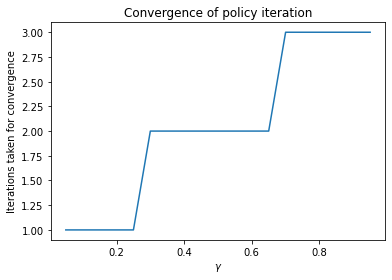

In [ ]:
kwargs = base_kwargs.copy()
env = TaxiEnv_HW2(**kwargs)
Results,extra_infos = run_policy_iteration(env)
dicts = extra_infos.values()
iters = []
gammas = np.arange(5, 100, 5)/100
for dictionary in dicts:
  iters.append(dictionary['number_iter'])
plt.plot(gammas,iters)
plt.title('Convergence of policy iteration')
plt.xlabel('$\gamma$')
plt.ylabel('Iterations taken for convergence');
# Note that if iters = 1 one step of policy evaluation and policy improvement 
# has happened. But that does not mean a new policy has been found, old policy 
# itself is optimal. (it checks whether old policy is equal to improved. If so,
# it is optimal)

2. Give alternate transition probabilities for action 2(if exists) such that optimal policy consists of action 2. Explain your answer

Your Answer:

Alternate transition probabilities: {-1:2/3, 0:1/6, 1:1/6}

It has been simulated in the next cell and we can see that the optimal policy has action 2 in several states. 
I improved the expected reward of action 2 and hence increased its chances at coming in optimal policy by:

a. Increased the probability of getting a ride (= p(-1) + p(1)) and in fact, made it more than that of action 1 ($\frac{5}{6}$ in action 2 compared to $\frac{3}{4}$ in action 1)

b. Probability of a '-1' transition is high. This is useful because, for the given environment '-1' transitions are often rewarded more than those rides corresponding to '+1' transition.

In [ ]:
new_kwargs = base_kwargs.copy()
new_kwargs["probabilities"]['2'] = {-1:2/3,0:1/6,1:1/6}
get_results(new_kwargs)

{'policy_iteration': {0.05: {'Expected Reward': {0: 6.890404255684389,
    1: 6.3079367097870085,
    2: 3.0828514583525526,
    3: 1.6275767211335066,
    4: 1.3502239982783635,
    5: 3.412542433425061},
   'Policy': {0: '2', 1: '2', 2: '2', 3: '2', 4: '1', 5: '1'}},
  0.1: {'Expected Reward': {0: 7.135732832428923,
    1: 6.642453588626351,
    2: 3.3618304210563275,
    3: 1.7781805092334164,
    4: 1.465328381812956,
    5: 3.5914458867010306},
   'Policy': {0: '2', 1: '2', 2: '2', 3: '2', 4: '1', 5: '1'}},
  0.15: {'Expected Reward': {0: 7.405982764113947,
    1: 7.007661839801358,
    2: 3.674880714792918,
    3: 1.9563672032580732,
    4: 1.5987980865832934,
    5: 3.7897498282360904},
   'Policy': {0: '2', 1: '2', 2: '2', 3: '2', 4: '1', 5: '1'}},
  0.2: {'Expected Reward': {0: 7.705308725024998,
    1: 7.408582551493351,
    2: 4.027659111108235,
    3: 2.167784034090722,
    4: 1.7551005620705085,
    5: 4.0113426230163345},
   'Policy': {0: '2', 1: '2', 2: '2', 3: '2', 4: '

# Submit to AIcrowd 🚀


In [ ]:
!DATASET_PATH=$AICROWD_DATASET_PATH \
aicrowd notebook submit \
    -c rl-assignment-2-taxi -a assets



/usr/local/lib/python3.7/dist-packages/aicrowd/notebook/helpers.py:361: UserWarning: `%aicrowd` magic command can be used to save the notebook inside jupyter notebook/jupyterLab environment and also to get the notebook directly from the frontend without mounting the drive in colab environment. You can use magic command to skip mounting the drive and submit using the code below:
 %load_ext aicrowd.magic
%aicrowd notebook submit -c rl-assignment-2-taxi -a assets
  warnings.warn(description + code)
Mounting Google Drive 💾
Your Google Drive will be mounted to access the colab notebook
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googlea